In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import faiss

In [85]:
# Same as part 5
def parse_descriptor_columns(df):
    for col in ['A3', 'D1', 'D2', 'D3', 'D4']:
        df[col] = df[col].apply(lambda x: np.fromstring(x, sep=','))
    feature_matrix = np.hstack([    
        df['surfaceAreaObj'].values.reshape(-1, 1),
        df['compactnessObj'].values.reshape(-1, 1),
        df['rectangularityObj'].values.reshape(-1, 1),
        df['diameterObj'].values.reshape(-1, 1),
        df['convexityObj'].values.reshape(-1, 1),
        df['eccentricityObj'].values.reshape(-1, 1),
        np.vstack(df['A3'].values),
        np.vstack(df['D1'].values),
        np.vstack(df['D2'].values),
        np.vstack(df['D3'].values),
        np.vstack(df['D4'].values)
    ])
    return feature_matrix

# Load descriptors with parsed columns
def load_descriptors(csv_filepath):
    if os.path.exists(csv_filepath):
        print("File found! Loading...")
        df = pd.read_csv(csv_filepath)
        feature_matrix = parse_descriptor_columns(df)
        return df, feature_matrix
    else:
        print(f"File not found at: {csv_filepath}")
        return None, None

# FAISS-based ANN Engine for Evaluation
class ANNEvaluationEngine:
    def __init__(self, feature_dim, nlist=100):
        self.feature_dim = feature_dim
        self.nlist = nlist  # Number of clusters for the inverted index
        self.index = faiss.IndexIVFFlat(faiss.IndexFlatL2(feature_dim), feature_dim, nlist)
        self.index.nprobe = 10  # Number of clusters to search (controls accuracy/speed)

    def train_index(self, features):
        features = np.ascontiguousarray(features, dtype=np.float32)  # Ensure correct format
        print("Training the FAISS index with clustering for ANN...")
        self.index.train(features)  # Train on the feature set
        self.index.add(features)  # Add features to the trained FAISS index

    def query(self, query_vector, k=4):
        query_vector = np.ascontiguousarray(query_vector.reshape(1, -1), dtype=np.float32)
        distances, indices = self.index.search(query_vector, k + 1)  # Search for k+1 neighbors to exclude self
        indices, distances = indices[0][1:k+1], distances[0][1:k+1]  # Exclude the query shape itself
        return indices, distances

# Calculate precision and recall
def calculate_precision_recall(df, knn_engine, feature_matrix, k=7):
    correct_matches = 0
    total_relevant = 0
    total_retrieved = 0
    precision_per_class = {}
    recall_per_class = {}

    for idx, query_shape in df.iterrows():
        query_vector = feature_matrix[idx]
        query_class = query_shape['class']
        
        # Retrieve k-nearest neighbors using FAISS
        neighbors, _ = knn_engine.query(query_vector, k=k)

        # Calculate true positives
        relevant_retrieved = sum(1 for neighbor_idx in neighbors if df.iloc[neighbor_idx]['class'] == query_class)
        total_relevant += sum(1 for _ in df[df['class'] == query_class].index)
        correct_matches += relevant_retrieved
        total_retrieved += k

        # Precision and Recall per class
        if query_class not in precision_per_class:
            precision_per_class[query_class] = []
            recall_per_class[query_class] = []
        
        precision = relevant_retrieved / k if k > 0 else 0
        recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0

        precision_per_class[query_class].append(precision)
        recall_per_class[query_class].append(recall)

    # Calculate aggregate precision and recall for each class
    avg_precision_per_class = {cls: np.mean(precisions) for cls, precisions in precision_per_class.items()}
    avg_recall_per_class = {cls: np.mean(recalls) for cls, recalls in recall_per_class.items()}

    # Grand aggregate (overall precision and recall)
    overall_precision = correct_matches / total_retrieved if total_retrieved > 0 else 0
    overall_recall = correct_matches / total_relevant if total_relevant > 0 else 0

    return avg_precision_per_class, avg_recall_per_class, overall_precision, overall_recall

def main():
    csv_filepath = r'dataBaseNormalised.csv'

    # Load the descriptors
    df, feature_matrix = load_descriptors(csv_filepath)
    if df is None or feature_matrix is None:
        print("Failed to load descriptors. Exiting.")
        return

    # Initialize and train the FAISS ANN index
    ann_engine = ANNEvaluationEngine(feature_dim=feature_matrix.shape[1])
    ann_engine.train_index(feature_matrix)

    # Set K for ANN
    k = 7

    # Calculate precision and recall
    avg_precision_per_class, avg_recall_per_class, overall_precision, overall_recall = calculate_precision_recall(df, ann_engine, feature_matrix, k=k)

    # Display results
    print("Average Precision per Class:")
    for cls, precision in avg_precision_per_class.items():
        print(f"Class {cls}: Precision = {precision:.2f}")
    
    print("\nAverage Recall per Class:")
    for cls, recall in avg_recall_per_class.items():
        print(f"Class {cls}: Recall = {recall:.2f}")
    
    print(f"\nOverall Precision: {overall_precision:.2f}")
    print(f"Overall Recall: {overall_recall:.2f}")

main()

File found! Loading...
Training the FAISS index with clustering for ANN...
Average Precision per Class:
Class AircraftBuoyant: Precision = 0.07
Class Apartment: Precision = 0.06
Class AquaticAnimal: Precision = 0.12
Class Bed: Precision = 0.06
Class Bicycle: Precision = 0.52
Class Biplane: Precision = 0.29
Class Bird: Precision = 0.19
Class Bookset: Precision = 0.17
Class Bottle: Precision = 0.18
Class BuildingNonResidential: Precision = 0.05
Class Bus: Precision = 0.07
Class Car: Precision = 0.48
Class Cellphone: Precision = 0.47
Class Chess: Precision = 0.13
Class City: Precision = 0.10
Class ClassicPiano: Precision = 0.10
Class Computer: Precision = 0.13
Class ComputerKeyboard: Precision = 0.27
Class Cup: Precision = 0.13
Class DeskLamp: Precision = 0.06
Class DeskPhone: Precision = 0.06
Class Door: Precision = 0.13
Class Drum: Precision = 0.11
Class Fish: Precision = 0.06
Class FloorLamp: Precision = 0.01
Class Glasses: Precision = 0.07
Class Guitar: Precision = 0.09
Class Gun: Pre

In [79]:
import os
import pandas as pd
import numpy as np
import faiss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class KNNEngine:
    def __init__(self, feature_dim, nlist=100, nprobe=10):
        self.feature_dim = feature_dim
        self.nlist = nlist  # Number of clusters
        self.nprobe = nprobe  # Number of clusters to search within

        # Initialize a quantizer for clustering
        self.quantizer = faiss.IndexFlatL2(feature_dim)  
        # Create an IVF index for approximate search
        self.index = faiss.IndexIVFFlat(self.quantizer, feature_dim, nlist)
        self.index.nprobe = nprobe  # Set the number of clusters to search

    def build_index(self, features):
        features = np.ascontiguousarray(features, dtype=np.float32)
        # Train the index for clustering (necessary for IVF)
        self.index.train(features)
        # Add features to the index
        self.index.add(features)

    def query(self, query_vector, k=5):
        query_vector = np.ascontiguousarray(query_vector.reshape(1, -1), dtype=np.float32)
        # Perform the ANN search
        distances, indices = self.index.search(query_vector, k + 1)
        # Exclude the query itself from results
        indices, distances = indices[0][1:k+1], distances[0][1:k+1]
        return indices, distances

class DimensionalityReducer:
    def __init__(self, features):
        self.features = features

    def apply_tsne(self):
        tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        reduced_features = tsne.fit_transform(self.features)
        return reduced_features

def parse_descriptor_columns(df):
    for col in ['A3', 'D1', 'D2', 'D3', 'D4']:
        df[col] = df[col].apply(lambda x: np.fromstring(x, sep=','))

    feature_matrix = np.hstack([
        df['surfaceAreaObj'].values.reshape(-1, 1),
        df['compactnessObj'].values.reshape(-1, 1),
        df['rectangularityObj'].values.reshape(-1, 1),
        df['diameterObj'].values.reshape(-1, 1),
        df['convexityObj'].values.reshape(-1, 1),
        df['eccentricityObj'].values.reshape(-1, 1),
        np.vstack(df['A3'].values),
        np.vstack(df['D1'].values),
        np.vstack(df['D2'].values),
        np.vstack(df['D3'].values),
        np.vstack(df['D4'].values)
    ])
    return feature_matrix

def load_descriptors(csv_filepath):
    if os.path.exists(csv_filepath):
        print("File found! Loading...")
        df = pd.read_csv(csv_filepath)
        feature_matrix = parse_descriptor_columns(df)
        return df, feature_matrix
    else:
        print(f"File not found at: {csv_filepath}")
        return None, None

def visualize_tsne_2d(reduced_features, labels, highlight_index=None, title="t-SNE Visualization"):
    plt.figure(figsize=(12, 8))
    
    unique_labels = np.unique(labels)
    colors = cm.get_cmap("tab20", len(unique_labels))  # Use 'tab20' for up to 20 distinct colors

    for idx, label in enumerate(unique_labels):
        indices = np.where(labels == label)
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], 
                    label=label, color=colors(idx), s=50, alpha=0.7)

    if highlight_index is not None:
        plt.scatter(reduced_features[highlight_index, 0], reduced_features[highlight_index, 1], 
                    color='red', s=100, edgecolor='black', label='Selected Shape', zorder=5)

    plt.title(title, fontsize=16)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left', 
               borderaxespad=0., fontsize='small', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def perform_ann_for_all_objects(csv_filepath):
    df, features = load_descriptors(csv_filepath)
    
    if df is None or features is None:
        print("Failed to load descriptors. Exiting.")
        return
    
    # Initialize KNN engine with ANN using IVF indexing
    knn = KNNEngine(feature_dim=features.shape[1], nlist=100, nprobe=10)
    knn.build_index(features)

    results_list = []

    for idx in range(len(df)):
        query_vector = features[idx]
        
        neighbors, distances = knn.query(query_vector)

        result_dict = {
            "object": df.iloc[idx]['name'],
            "class": df.iloc[idx]['class'],
            "neighbors": [df.iloc[n]['class'] for n in neighbors],
            "distances": distances.tolist(),
            "top_10_neighbors": [df.iloc[n]['class'] for n in neighbors[:10]]
        }
        
        results_list.append(result_dict)

    results_df = pd.DataFrame(results_list)
    
    return results_df

# Example usage:
csv_filepath = r'dataBaseNormalised.csv'
results_df = perform_ann_for_all_objects(csv_filepath)
results_df.head


File found! Loading...


<bound method NDFrame.head of           object            class  \
0      m1337.obj  AircraftBuoyant   
1      m1338.obj  AircraftBuoyant   
2      m1339.obj  AircraftBuoyant   
3      m1340.obj  AircraftBuoyant   
4      m1341.obj  AircraftBuoyant   
...          ...              ...   
2476   m1574.obj            Truck   
2477  D00499.obj       WheelChair   
2478  D00056.obj            Truck   
2479  D00526.obj       WheelChair   
2480  D00604.obj       WheelChair   

                                              neighbors  \
0     [HumanHead, HumanHead, HumanHead, House, Human...   
1     [HumanHead, Monitor, HumanHead, HumanHead, Hum...   
2      [PlantWildNonTree, PlantIndoors, Tree, Bed, Jet]   
3     [BuildingNonResidential, DeskLamp, Hand, Hand,...   
4                [Chess, Chess, Jet, FloorLamp, Violin]   
...                                                 ...   
2476  [PianoBoard, NonWheelChair, Musical_Instrument...   
2477  [PlantIndoors, PlantIndoors, WheelChair, NonWh.

In [80]:
results = results_df


In [81]:
# Assuming results_df is already available from the previous code

def count_top_10_neighbors(results_df):
    # Initialize an empty dictionary to store the counts
    class_counts = {}

    # Iterate over each unique class in the results_df
    for unique_class in results_df['class'].unique():
        # Filter the DataFrame for the current unique class
        class_df = results_df[results_df['class'] == unique_class]

        # Initialize a dictionary to store counts for the current unique class
        neighbor_counts = {}

        # Iterate over each row in the filtered DataFrame
        for _, row in class_df.iterrows():
            # Get the top 10 neighbors for the current object
            top_10_neighbors = row['top_10_neighbors']

            # Count the occurrences of each neighbor class
            for neighbor_class in top_10_neighbors:
                if neighbor_class in neighbor_counts:
                    neighbor_counts[neighbor_class] += 1
                else:
                    neighbor_counts[neighbor_class] = 1

        # Store the counts for the current unique class in the main dictionary
        class_counts[unique_class] = neighbor_counts

    # Convert the dictionary to a DataFrame for better readability
    counts_df = pd.DataFrame(class_counts).fillna(0).astype(int)

    return counts_df

# Example usage:
counts_df = count_top_10_neighbors(results)
print(counts_df)

                  AircraftBuoyant  Apartment  AquaticAnimal  Bed  Bicycle  \
HumanHead                      23          6              2    1        0   
House                           4         15              2    3        0   
Monitor                         2          2              0    2        2   
PlantWildNonTree                1          1              1    0        0   
PlantIndoors                    1          1              1    1        2   
...                           ...        ...            ...  ...      ...   
Truck                           0          0              0    1        1   
Bicycle                         0          0              0    2       74   
Biplane                         0          0              0    0       10   
Sword                           0          0              0    0        0   
Guitar                          0          0              0    0        0   

                  Biplane  Bird  Bookset  Bottle  BuildingNonResidential  .

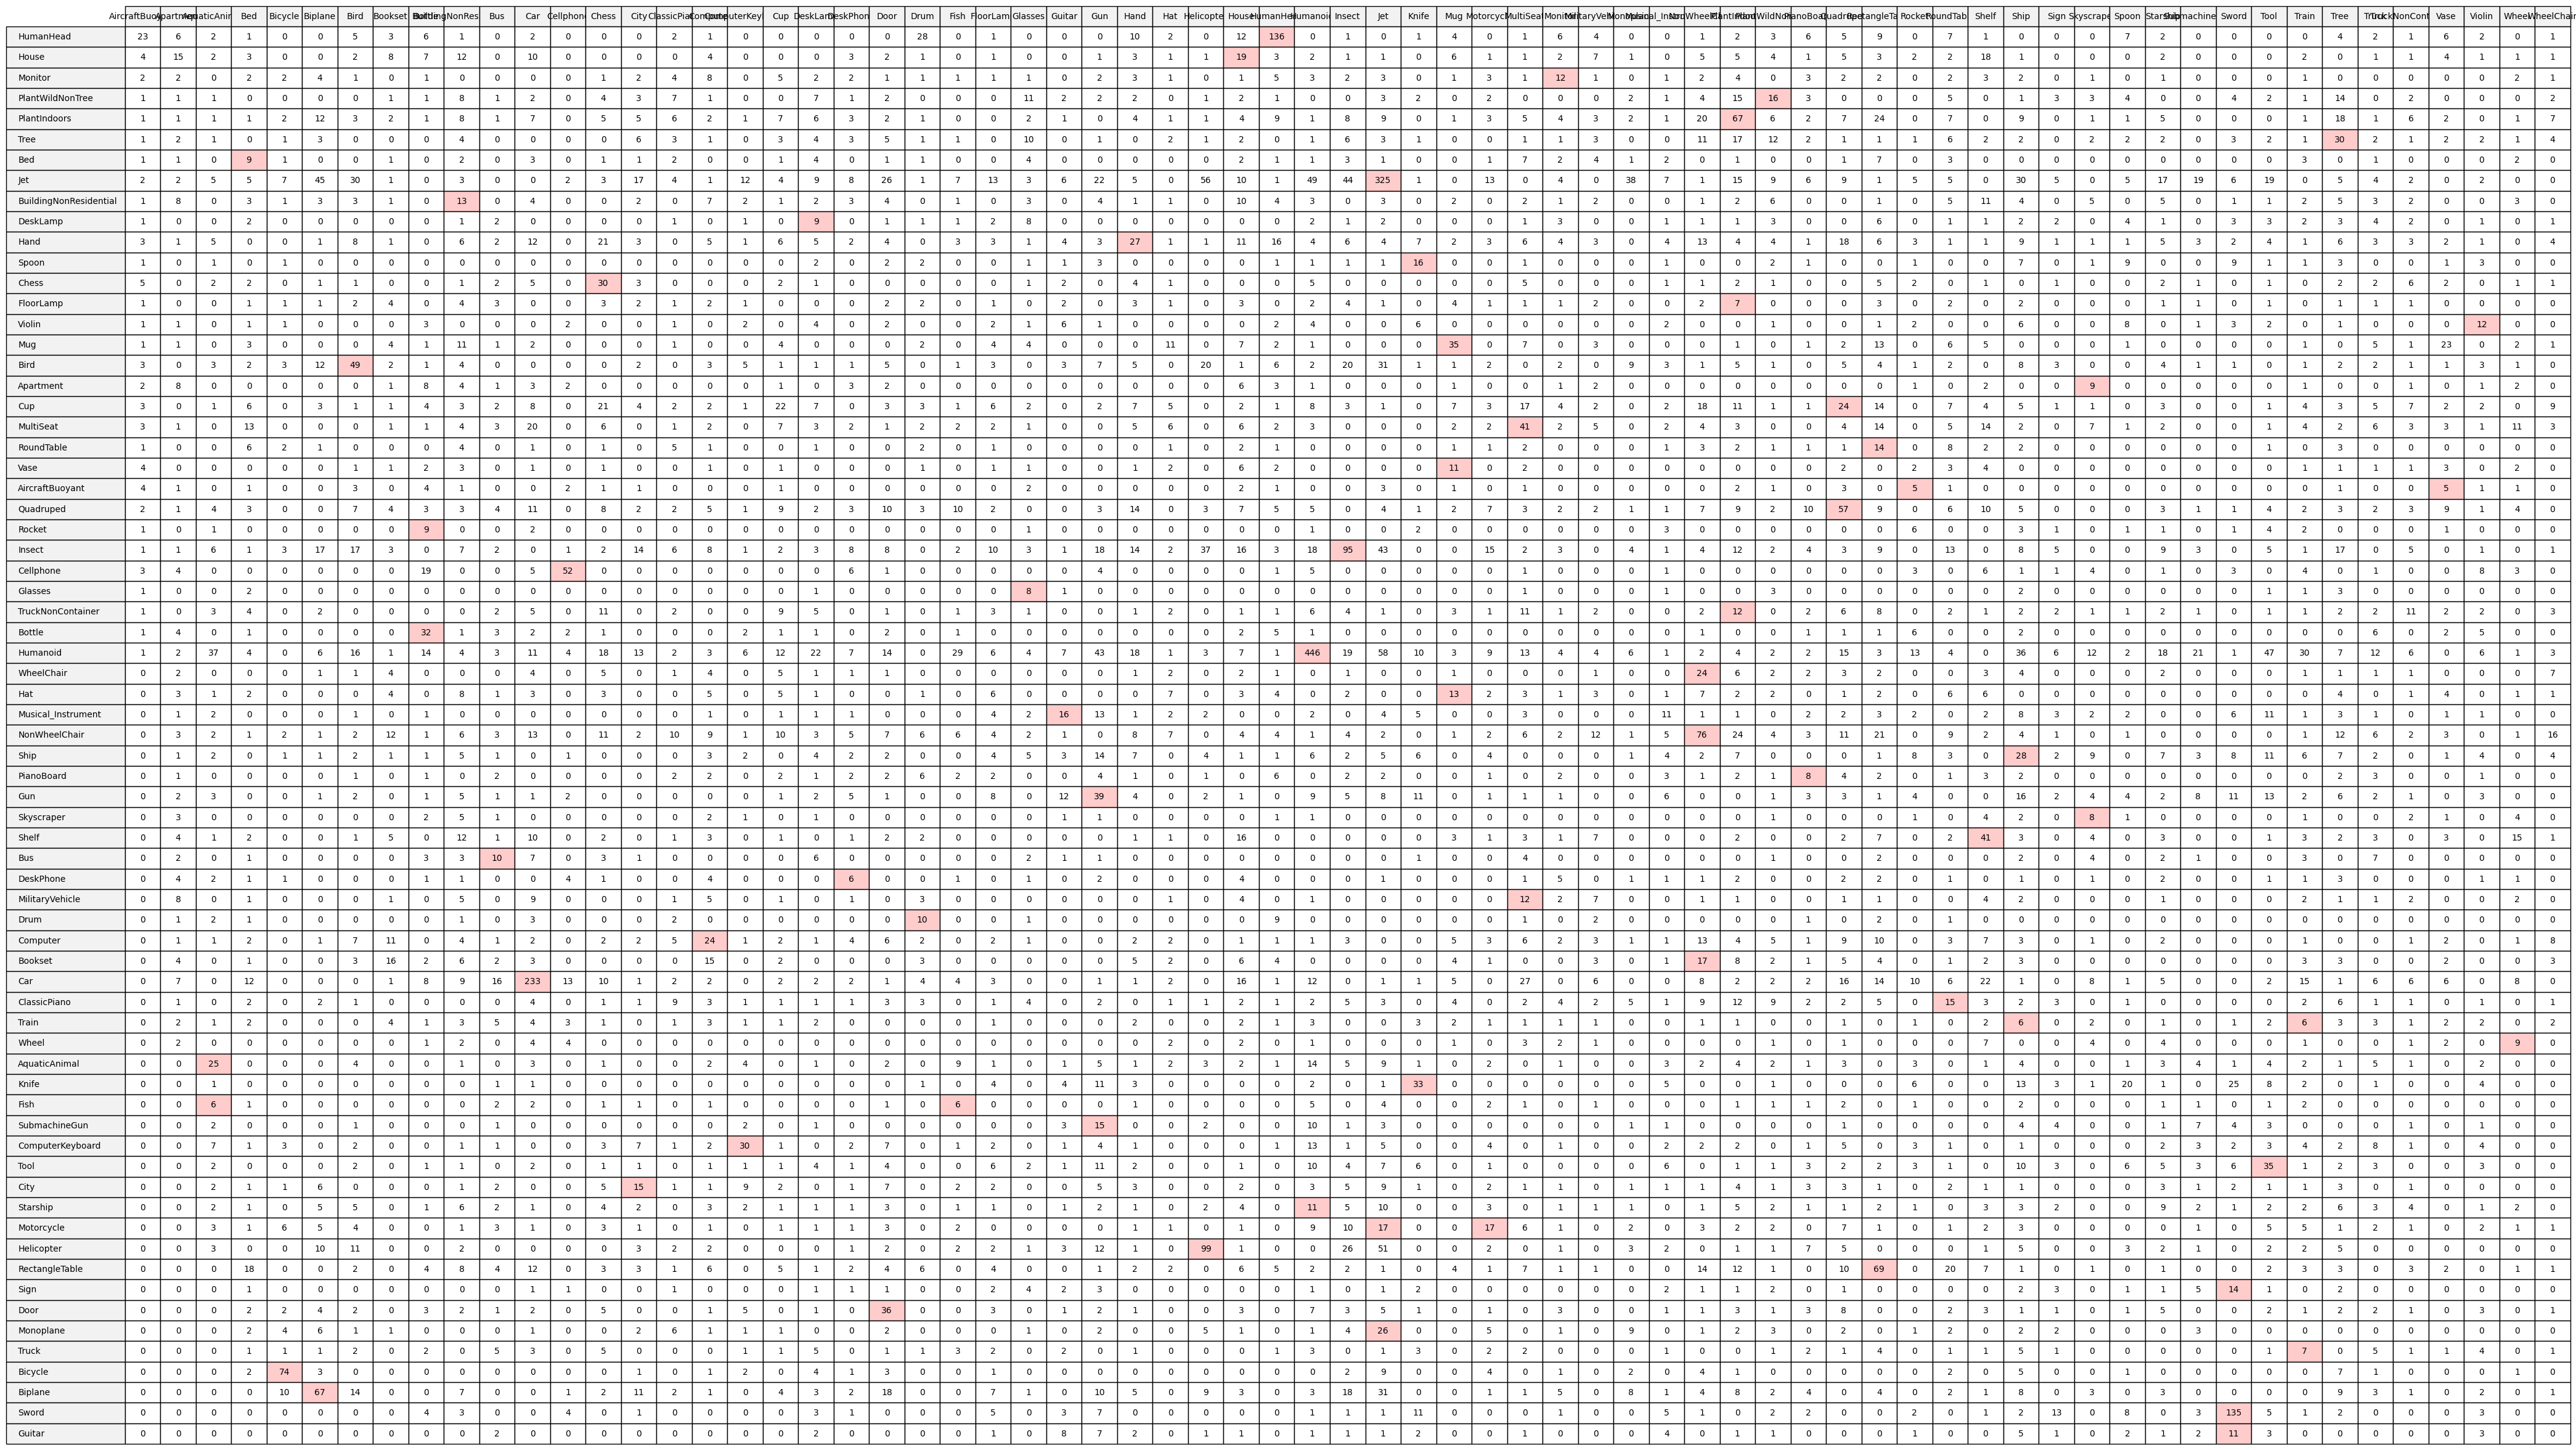

In [82]:
# Assuming counts_df is already available from the previous code

def visualize_counts_df(counts_df):
    fig, ax = plt.subplots()  # Set the figure size

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=counts_df.values,
                     colLabels=counts_df.columns,
                     rowLabels=counts_df.index,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*counts_df.shape[1],
                     rowColours=['#f2f2f2']*counts_df.shape[0])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(8, 2)  # Adjust the scale of the table
# Highlight the highest number in each row
    for i, row in enumerate(counts_df.values):
        max_val = np.max(row)
        for j, cell in enumerate(row):
            if cell == max_val:
                table[(i+1, j)].set_facecolor('#ffcccc')  # Highlight color

    plt.show()

# Example usage:
visualize_counts_df(counts_df)


               Unique Class              First Most  \
0      AircraftBuoyant (80)          HumanHead (23)   
1           Apartment (115)              House (15)   
2       AquaticAnimal (145)           Humanoid (37)   
3                 Bed (135)     RectangleTable (18)   
4             Bicycle (130)            Bicycle (74)   
..                      ...                     ...   
64  TruckNonContainer (100)  TruckNonContainer (11)   
65               Vase (100)                Mug (23)   
66             Violin (100)             Violin (12)   
67               Wheel (85)              Shelf (15)   
68          WheelChair (90)      NonWheelChair (16)   

                   Second Most            Third Most          Fourth Most  \
0                    Chess (5)             House (4)             Vase (4)   
1   BuildingNonResidential (8)         Apartment (8)  MilitaryVehicle (8)   
2           AquaticAnimal (25)  ComputerKeyboard (7)           Insect (6)   
3               MultiSeat (13) 

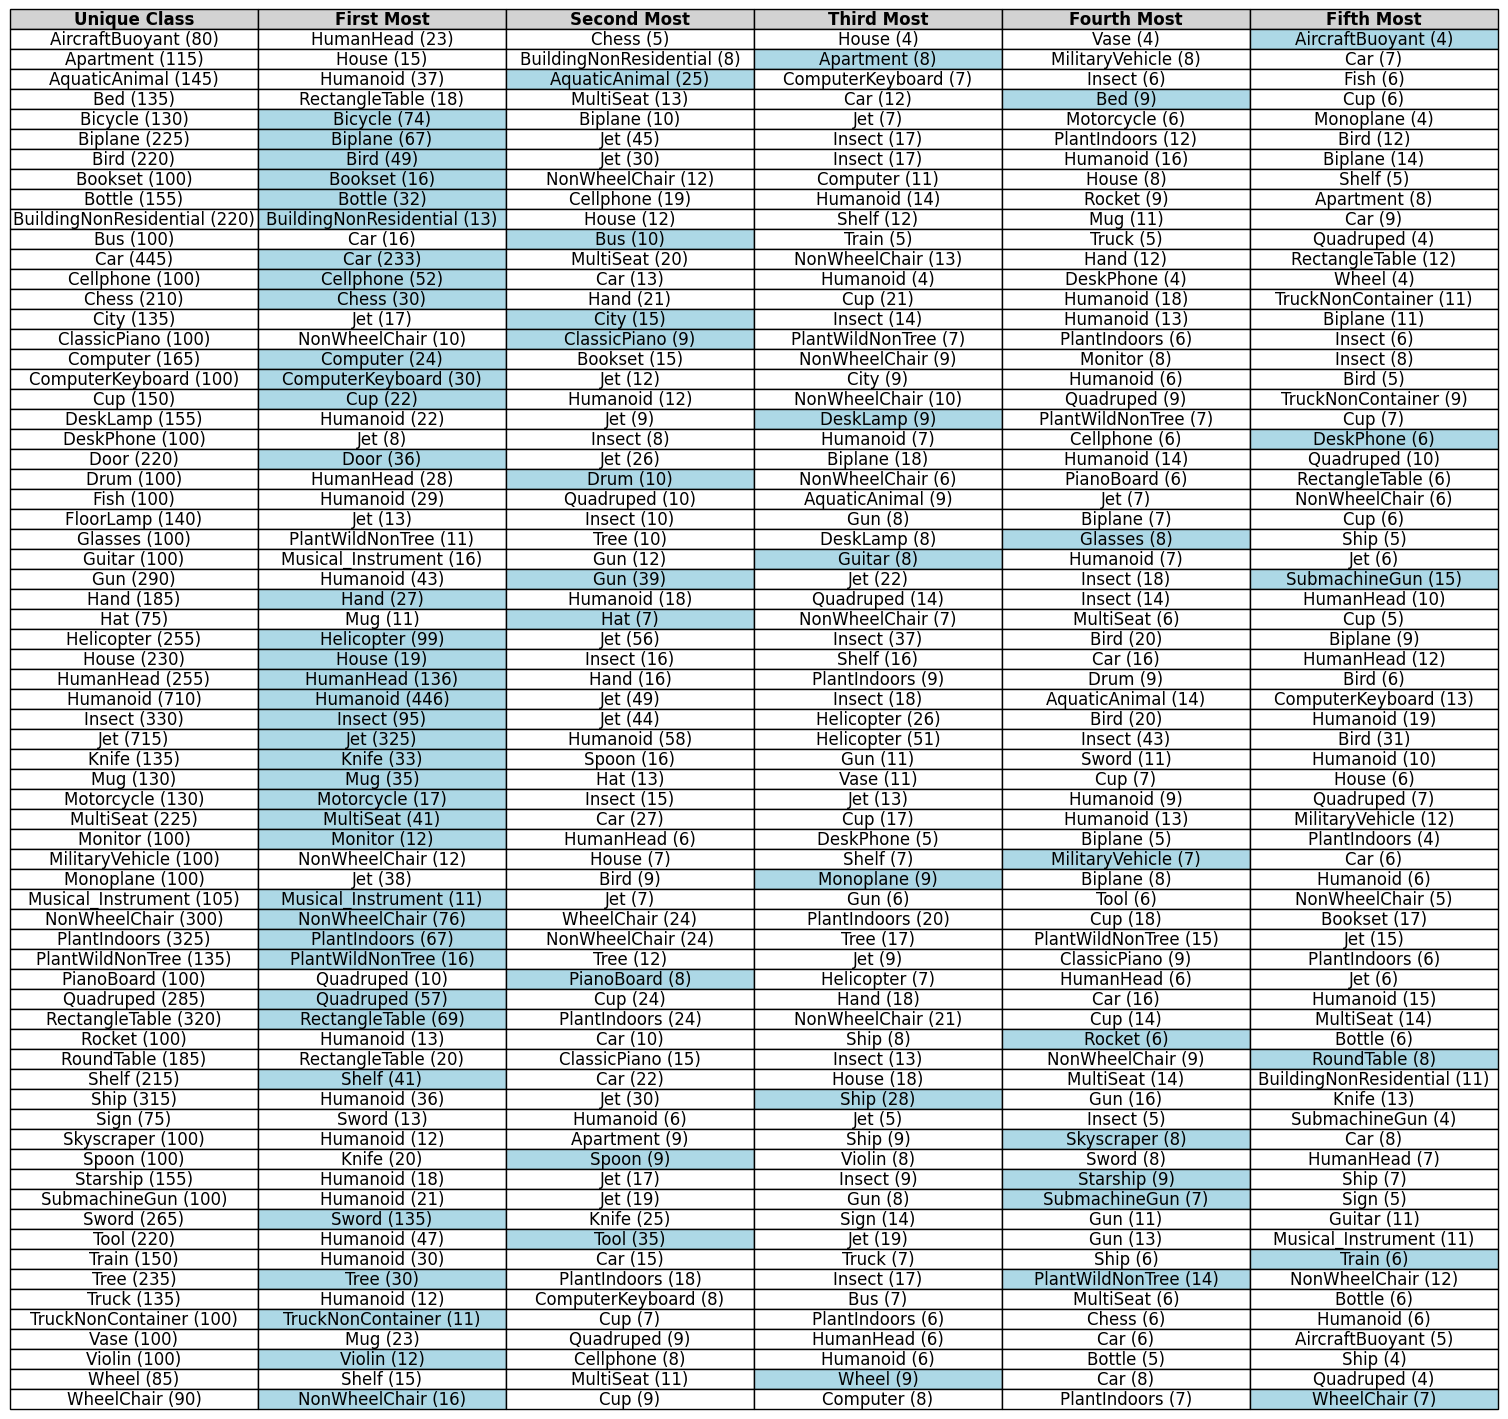

In [77]:
import pandas as pd

# Assuming counts_df is already available from the previous code

def get_top_5_classes_with_columns(counts_df):
    top_5_list = []

    # Iterate over each unique class in the counts_df
    for unique_class in counts_df.columns:
        # Get the counts for the current unique class
        class_counts = counts_df[unique_class]

        # Get the top 5 mentioned classes
        top_5_classes = class_counts.nlargest(5)

        # Create a dictionary to store the top 5 classes with their ranks
        top_5_dict = {
            'Unique Class': f"{ unique_class} ({int(class_counts.sum())})",
            'First Most': f"{top_5_classes.index[0]} ({top_5_classes.iloc[0]})" if len(top_5_classes) > 0 else None,
            'Second Most': f"{top_5_classes.index[1]} ({top_5_classes.iloc[1]})" if len(top_5_classes) > 1 else None,
            'Third Most': f"{top_5_classes.index[2]} ({top_5_classes.iloc[2]})" if len(top_5_classes) > 2 else None,
            'Fourth Most': f"{top_5_classes.index[3]} ({top_5_classes.iloc[3]})" if len(top_5_classes) > 3 else None,
            'Fifth Most': f"{top_5_classes.index[4]} ({top_5_classes.iloc[4]})" if len(top_5_classes) > 4 else None
        }

        # Append the dictionary to the list
        top_5_list.append(top_5_dict)

    # Convert the list to a DataFrame for better readability
    top_5_df = pd.DataFrame(top_5_list)

    return top_5_df

# Example usage:
# Assuming counts_df is already defined
top_5_df = get_top_5_classes_with_columns(counts_df)
print(top_5_df)


import matplotlib.pyplot as plt

# Function to visualize the top_5_df as a nice table with bold headers, light grey background, and light blue color for matching classes
def visualize_top_5_df_with_styling_and_highlight(top_5_df):
    fig, ax = plt.subplots()  # Set the figure size

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=top_5_df.values,
                     colLabels=top_5_df.columns,
                     cellLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(3, 1.2)  # Adjust the scale of the table

    # Style the header
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(weight='bold')  # Make header text bold
            cell.set_facecolor('#d3d3d3')  # Light grey background

    # Highlight the class that is the same as the unique class with light blue color
    for i, row in enumerate(top_5_df.values):
        unique_class = row[0].split(' (')[0]  # Extract the unique class name
        for j, cell in enumerate(row[1:], start=1):
            if unique_class in cell:
                table[(i+1, j)].set_facecolor('#add8e6')  # Light blue color

    plt.show()

# Example usage:
visualize_top_5_df_with_styling_and_highlight(top_5_df)





In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the CSV file into a DataFrame
df = pd.read_csv('dataBaseFinal.csv')

# Identify the columns to normalize (all columns before 'A3')
columns_to_normalize = df.columns[2:df.columns.get_loc('A3')]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Save the DataFrame with normalized columns back to a CSV file
df.to_csv('dataBaseNormalised.csv', index=False)

print(df)

            name            class  surfaceAreaObj  compactnessObj  \
0      m1337.obj  AircraftBuoyant        0.062507        0.190314   
1      m1338.obj  AircraftBuoyant        0.076098        0.118766   
2      m1339.obj  AircraftBuoyant        0.062308        0.027127   
3      m1340.obj  AircraftBuoyant        0.055899        0.157963   
4      m1341.obj  AircraftBuoyant        0.036642        0.148534   
...          ...              ...             ...             ...   
2476   m1574.obj            Truck        0.087538        0.015458   
2477  D00499.obj       WheelChair        0.025207        0.019580   
2478  D00056.obj            Truck        0.053070        0.023135   
2479  D00526.obj       WheelChair        0.013901        0.049732   
2480  D00604.obj       WheelChair        0.004500        0.009013   

      rectangularityObj  diameterObj  convexityObj  eccentricityObj  \
0              0.141413     0.055581      0.219727         0.002270   
1              0.129760     0